# Sequence Density Estimation using Field Theory (SeqDEFT)

This notebook demonstrates how to do the following tasks in SeqDEFT:

(1) Trace the MAP curve, and find the optimal hyperparameter; <br>
(2) Visualize the optimal density; <br>
(3) Compute pairwise associations of the optimal density; <br>
(4) Perform posterior sampling using Hamiltonian Monte Carlo.

This demonstration employs a small example dataset simulated from the prior. Applications to sequence spaces with several hundred thousands of genotypes can be done on a typical laptop computer within days. For larger sequence spaces up to low millions of genotypes, it is strongly recommended to deploy the calculations on a cluster.

### Example

We consider a biological sequence space formed by short (length = 5) DNA sequences. The dimension of the space is equal to 1,024. These sequences are ordered in the lexicographical order: `AAAAA`, `AAAAC`, `AAAAG`, `AAAAT`, ..., `TTTTT`. The number of occurrence of each sequence will be simulated from the prior.

We use the 2nd order association (i.e. log odds ratio) as the "smoothness" measure of the density. The corresponding MaxEnt solution is then the independent sites model.  

In [1]:
#
# Import packages that will be needed later
#

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from matplotlib import gridspec
from matplotlib.collections import LineCollection

In [2]:
#
# Import functions of SeqDEFT
#

from functions import preliminary_preparation, simulate_data_from_prior, \
                      trace_MAP_curve, compute_log_Es, compute_log_Es_bounds, compute_log_Ls, \
                      make_visualization, get_nodes, get_edges, \
                      compute_log_ORs, \
                      posterior_sampling, compute_R_hat, combine_samples, plot_distribution

## Preliminary preparation

Specify the following parameters:

`alpha` = number of alleles <br>
`l` = sequence length <br>
`P` = order of association to compute 

This will set global parameters, and create/load graph Laplacian and its kernel basis.

In [3]:
alpha = 4
l = 5
P = 2

# ----------

preliminary_preparation(alpha, l, P)

Setting global parameters ...
Loading L ...
Loading D kernel basis ...
Constructing D spectrum ...


## Simulate data from the prior

Specify the following parameters:

`N` = number of data <br>
`a_true` = assumed value of the hyperparameter 

This will create a dictionary `data_dict` that contains the number `N` and the frequency `R` of the data, as well as the density `Q_true` generating the data. The product of `N` and `R` gives the number of occurrence of the sequences. 

In [4]:
N = 10000
a_true = 100

# ----------

data_dict = simulate_data_from_prior(N, a_true, random_seed=0)
data_dict

{'N': 10000,
 'Q_true': array([3.02898538e-06, 1.00150515e-04, 4.02625966e-05, ...,
        4.64508913e-05, 1.51595234e-04, 1.14668340e-03]),
 'R': array([0.    , 0.0002, 0.    , ..., 0.0001, 0.0001, 0.0012])}

## (1) Trace the MAP curve, and find the optimal hyperparameter

### (1a) Trace the MAP curve

Specify the following parameters:

`resolution` = target geodesic distance between two densities <br>
`num_a` = number of values of the hyperparameter to compute along the MAP curve

This will trace the MAP curve. If `num_a` is specified, `num_a` values of the hyperparameter will be computed, in addition to zero and infinity. Otherwise, the function will find as many values of the hyperparameter as it needs such that any pair of adjacent densities has a geodesic distance less than `resolution`. In either case, `resolution` is also used to find a minimum and a maximum finite value of the hyperparameter. The resulting MAP curve will consist of hyperparameter values between these two extremes. The result will be saved in the dataframe `df_map`.

**Note 1.** The computation will take about 5 seconds. <br>
**Note 2.** In some cases, when the hyperparameter is very large or very small, the minimization algorithm may return an error message, such as `ABNORMAL_TERMINATION_IN_LNSRCH` or `STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT`. There are (at least) two ways to deal with this situation. (1) We can simply discard these extreme values of the hyperparameter, as long as this does not affect the determination of the optimal hyperparameter. (2) We can make the numerical convergence criterion less strict by increasing `gtol` in `options`, as long as the (premature) solution is good enough. The MAP estimate of the field, denoted $\phi^a$, must satisfy the following equation:
\begin{equation}
\sum_{i=1}^G e^{-\phi^a_i} = 1
\end{equation}
where $G$ is the dimension of the space. This equation holds for any value of the hyperparameter. 

In [5]:
resolution = 0.1
num_a = 20

# ----------

df_map = trace_MAP_curve(data_dict, resolution, num_a, options={'ftol':1e-100, 'gtol':1e-3})

Computing a = inf ...
Computing a_max = 23040.000000 ...
... D_geo(Q_max, Q_inf) = 0.693012
Computing a_max = 230400.000000 ...
... D_geo(Q_max, Q_inf) = 0.106456
Computing a_max = 2304000.000000 ...
... D_geo(Q_max, Q_inf) = 0.010510

Computing a = 0 ...
Computing a_min = 0.023040 ...
... D_geo(Q_min, Q_0) = 0.007539

Partitioning the MAP curve into 20 points ...
Computing a_18 = 873835.819945 ...
Computing a_17 = 331418.854261 ...
Computing a_16 = 125696.903758 ...
Computing a_15 = 47672.941389 ...
Computing a_14 = 18080.869717 ...
Computing a_13 = 6857.513722 ...
Computing a_12 = 2600.842502 ...
Computing a_11 = 986.418985 ...
Computing a_10 = 374.118161 ...
Computing a_9 = 141.891428 ...
Computing a_8 = 53.815023 ...
Computing a_7 = 20.410371 ...
Computing a_6 = 7.741021 ...
Computing a_5 = 2.935930 ...
Computing a_4 = 1.113507 ...
Computing a_3 = 0.422319 ...
Computing a_2 = 0.160172 ...
Computing a_1 = 0.060748 ...


### (1b) Compute Bayesian evidence ratio and its bounds

This will compute Bayesian evidence ratio (which is suitable for small problems only) and its lower and upper bounds. The result will be saved in the dataframe `df_map`.

**Note.** The computation of Bayesian evidence ratio will take about 1 minute, and the computation of the bounds will take less than 1 second. 

In [6]:
df_map = compute_log_Es(data_dict, df_map)
df_map = compute_log_Es_bounds(data_dict, df_map)

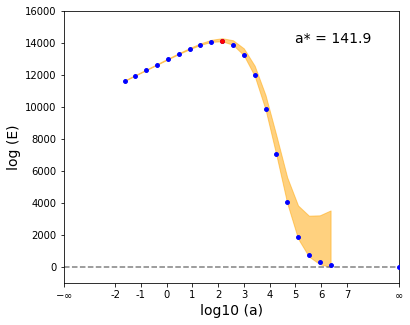

In [7]:
#
# Make plot
#

aa = df_map['a'].values
log_Es = df_map['log_E'].values
log_Es_lb, log_Es_ub = df_map['log_E_lb'].values, df_map['log_E_ub'].values

a_star = aa[log_Es.argmax()]
max_log_E = log_Es.max()

# ----------

plt.figure(figsize=(6,5))

with np.errstate(divide='ignore'):
    plt.fill_between(np.log10(aa), log_Es_lb, log_Es_ub, color='orange', alpha=0.5, zorder=1)
    plt.hlines(0, xmin=-4, xmax=9, color='grey', linestyles='--', zorder=2)
    plt.scatter(np.log10(aa), log_Es, color='blue', s=15, zorder=3)
    plt.scatter(9, log_Es[-1], color='blue', s=15, zorder=3)
    plt.scatter(np.log10(a_star), max_log_E, color='red', s=15, zorder=4)
    
plt.annotate(s=('a* = %.1f'%a_star), xy=(5, 14000), fontsize=14)

plt.xlim(-4, 9)
plt.ylim(-1000, 16000)
plt.xticks([-4, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 9], [r'$-\infty$','-2','-1','0','1','2','3','4','5','6','7',r'$\infty$'])
plt.xlabel('log10 (a)', fontsize=14)
plt.ylabel('log (E)', fontsize=14)
plt.show()

### (1c) Compute cross-validated likelihood

Specify the following parameters:

`cv_fold` = number of partitions of the data

This will compute data likelihood by doing `cv_fold`-fold cross validation. The result will be saved in the dataframe `df_map`.

**Note 1.** The computation will take about 12 seconds. <br>
**Note 2.** See Note 2 in (1a) for details about the numerical solutions and related issues.

In [8]:
cv_fold = 5

# ----------

df_map = compute_log_Ls(data_dict, df_map, cv_fold, random_seed=0, options={'ftol':1e-100, 'gtol':1e-3})

Doing cross validation fold # 0 ...
Doing cross validation fold # 1 ...
Doing cross validation fold # 2 ...
Doing cross validation fold # 3 ...
Doing cross validation fold # 4 ...


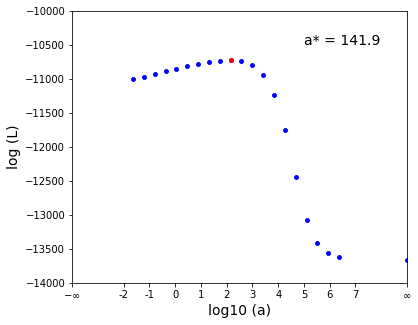

In [9]:
#
# Make plot
#

aa = df_map['a'].values
log_Ls = df_map['log_L'].values

a_star = aa[log_Ls.argmax()]
max_log_L = log_Ls.max()

# ----------

plt.figure(figsize=(6,5))

with np.errstate(divide='ignore'):
    plt.scatter(np.log10(aa), log_Ls, color='blue', s=15, zorder=1)
    plt.scatter(9, log_Ls[-1], color='blue', s=15, zorder=1)
    plt.scatter(np.log10(a_star), max_log_L, color='red', s=15, zorder=2)

plt.annotate(s=('a* = %.1f'%a_star), xy=(5, -10500), fontsize=14)

plt.xlim(-4, 9)
plt.ylim(-14000, -10000)
plt.xticks([-4, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 9], [r'$-\infty$','-2','-1','0','1','2','3','4','5','6','7',r'$\infty$'])
plt.xlabel('log10 (a)', fontsize=14)
plt.ylabel('log (L)', fontsize=14)
plt.show()

### (1d) Determine the optimal hyperparameter, and compare the MAP estimate with the true distribution

We use the more general cross-validated likelihood to determine the optimal hyperparameter and the corresponding field and density. Then we compare the corresponding MAP estimate to the true distribution.

In [10]:
aa = df_map['a'].values
phis = df_map['phi'].values
log_Ls = df_map['log_L'].values

a_star = aa[log_Ls.argmax()]
phi_star = phis[log_Ls.argmax()]
Q_star = np.exp(-phi_star) / np.sum(np.exp(-phi_star))

print('a_true = %.1f' % a_true)
print('a_star = %.1f' % a_star)

a_true = 100.0
a_star = 141.9


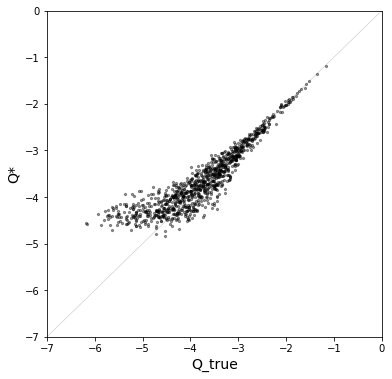

In [11]:
#
# Make plot
#

Q_true = data_dict['Q_true']

plt.figure(figsize=(6,6))
plt.plot([-7,0], [-7,0], color='grey', linewidth=0.5, alpha=0.5, zorder=1)
plt.scatter(np.log10(Q_true), np.log10(Q_star), color='black', s=5, alpha=0.4, zorder=2)
plt.xlim(-7, 0)
plt.ylim(-7, 0)
plt.xlabel('Q_true', fontsize=14)
plt.ylabel('Q*', fontsize=14)
plt.show()

## (2) Visualize the optimal density

### (2a) Compute visualization coordinates

Specify the following parameters:

`markov_chain` = model that will be used to build transition matrix of the Markov chain <br>
`K` = number of visualization coordinates

This will compute `K` visualization coordinates of the optimal density with the `markov_chain` model. The result will be saved in the dataframe `df_visual`. The first visualization coordinate is a constant vector, and hence, will not be used.

**Note.** The computation will take about 1 second.

In [12]:
markov_chain = 'evolutionary'
K = 20

# ----------

df_visual, _ = make_visualization(Q_star, markov_chain, K)

Constructing A and c ...
Computing dominant eigenvalues and eigenvectors of A ...


### (2b) Plot spectrum of the transition matrix

Plot reciprocal eigenvalue spectrum of the transition matrix. The reciprocal of an eigenvalue is proportional to the fraction of variation explained in that direction. 

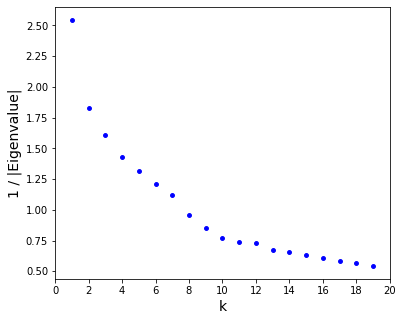

In [13]:
#
# Make plot
#

x = range(1, K)
y = 1 / abs(df_visual['eigenvalue'].values[1:])

plt.figure(figsize=(6,5))
plt.scatter(x, y, color='blue', s=15)
plt.xlim(0,)
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xlabel('k', fontsize=14)
plt.ylabel('1 / |Eigenvalue|', fontsize=14)
plt.show()

### (2c) Plot visualization of the optimal density

Specify the following parameters:

`kx` = the visualization coordinate to be plotted on x-axis <br>
`ky` = the visualization coordinate to be plotted on y-axis <br>

This will get the nodes and edges of the Hamming graph first, and then plot them in the figure. Each node is colored according to its density. The squared distance between two nodes in the figure is proportional to the commute time between these two nodes. 

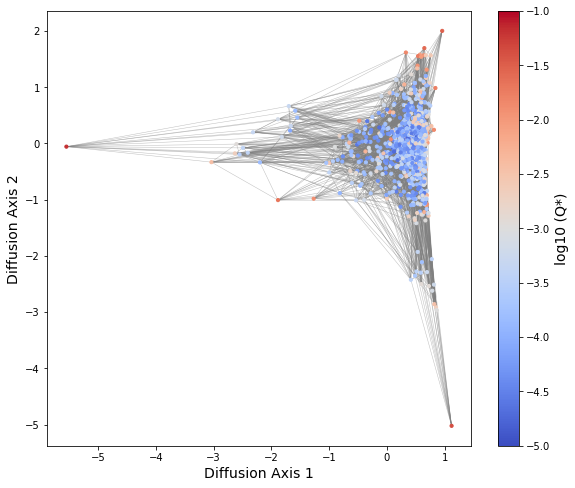

In [14]:
#
# Make plot
#

kx = 1
ky = 2

# ----------

df_nodes = get_nodes(df_visual, kx, ky)
df_edges = get_edges(df_visual, kx, ky)

plt.figure(figsize=(9.5,8))

edges = df_edges['edge'].values
ln_coll = LineCollection(edges, color='grey', linewidths=0.5, alpha=0.5, zorder=1)
ax = plt.gca()
ax.add_collection(ln_coll)
plt.draw()

nodes_x, nodes_y, nodes_c = df_nodes['x'].values, df_nodes['y'].values, np.log10(Q_star)
vmin, vmax = np.floor(np.log10(Q_star).min()), np.ceil(np.log10(Q_star).max())
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(nodes_x, nodes_y, c=nodes_c, vmin=vmin, vmax=vmax, cmap=cm, s=10, zorder=2)
plt.colorbar(sc).set_label(label='log10 (Q*)', size=14)

plt.xlabel('Diffusion Axis %d'%kx, fontsize=14)
plt.ylabel('Diffusion Axis %d'%ky, fontsize=14)            
plt.show()

## (3) Compute pairwise associations of the optimal density

### (3a) Specify mutations at each site

Here we simply generate mutations at each site alphabetically, and save the result in the dictionary `mutations_dict`. 

In [15]:
bases = ['A','C','G','T']

mutations_dict = {}
for i in range(l):
    mutations_dict[i] = list(itertools.combinations(bases, 2))
mutations_dict

{0: [('A', 'C'), ('A', 'G'), ('A', 'T'), ('C', 'G'), ('C', 'T'), ('G', 'T')],
 1: [('A', 'C'), ('A', 'G'), ('A', 'T'), ('C', 'G'), ('C', 'T'), ('G', 'T')],
 2: [('A', 'C'), ('A', 'G'), ('A', 'T'), ('C', 'G'), ('C', 'T'), ('G', 'T')],
 3: [('A', 'C'), ('A', 'G'), ('A', 'T'), ('C', 'G'), ('C', 'T'), ('G', 'T')],
 4: [('A', 'C'), ('A', 'G'), ('A', 'T'), ('C', 'G'), ('C', 'T'), ('G', 'T')]}

### (3b) Compute log odds ratios and their rms values

For every pair of sites, compute log odds ratios for all possible mutations at the two sites.

**Note.** The computation will take about 5 seconds.

In [16]:
num_mut = int(alpha*(alpha-1)/2)

log_ORs_dict, rms_log_ORs = {}, np.zeros([l*num_mut,l*num_mut])
for i in range(l):
    for j in range(l):
        if i == j:
            square_ij = np.zeros([num_mut,num_mut])
            for m in range(num_mut):
                for n in range(num_mut):
                    square_ij[m,n] = np.nan
            rms_log_ORs[i*num_mut:(i+1)*num_mut,j*num_mut:(j+1)*num_mut] = square_ij
        else:
            print('Computing log_ORs with given mutations at site %d & site %d ...'%(i,j))
            site_i, site_j = i, j
            site_i_muts, site_j_muts = mutations_dict[site_i], mutations_dict[site_j]
            dict_ij, k, square_ij = {}, 0, np.zeros([num_mut,num_mut])
            for m in range(num_mut):
                for n in range(num_mut):
                    site_i_mut, site_j_mut = site_i_muts[m], site_j_muts[n]
                    df_log_ORs = compute_log_ORs(phi_star, site_i, site_j, site_i_mut, site_j_mut, 
                                                 coding_dict={'A':0,'C':1,'G':2,'T':3})
                    log_ORs = df_log_ORs['log_OR'].values
                    dict_ij[k] = log_ORs
                    square_ij[m,n] = np.sqrt(np.mean(log_ORs**2))
                    k += 1
            log_ORs_dict[(i,j)] = dict_ij
            rms_log_ORs[i*num_mut:(i+1)*num_mut,j*num_mut:(j+1)*num_mut] = square_ij

Computing log_ORs with given mutations at site 0 & site 1 ...
Computing log_ORs with given mutations at site 0 & site 2 ...
Computing log_ORs with given mutations at site 0 & site 3 ...
Computing log_ORs with given mutations at site 0 & site 4 ...
Computing log_ORs with given mutations at site 1 & site 0 ...
Computing log_ORs with given mutations at site 1 & site 2 ...
Computing log_ORs with given mutations at site 1 & site 3 ...
Computing log_ORs with given mutations at site 1 & site 4 ...
Computing log_ORs with given mutations at site 2 & site 0 ...
Computing log_ORs with given mutations at site 2 & site 1 ...
Computing log_ORs with given mutations at site 2 & site 3 ...
Computing log_ORs with given mutations at site 2 & site 4 ...
Computing log_ORs with given mutations at site 3 & site 0 ...
Computing log_ORs with given mutations at site 3 & site 1 ...
Computing log_ORs with given mutations at site 3 & site 2 ...
Computing log_ORs with given mutations at site 3 & site 4 ...
Computin

### (3c) Plot effective association magnitudes

This will plot effective association magnitudes between any two sites, defined as exponential rms log odds ratios. Need to specify the following parameters:

`vmin` = minimum of exponential rms log odds ratios <br>
`vmax` = maximum of exponential rms log odds ratios

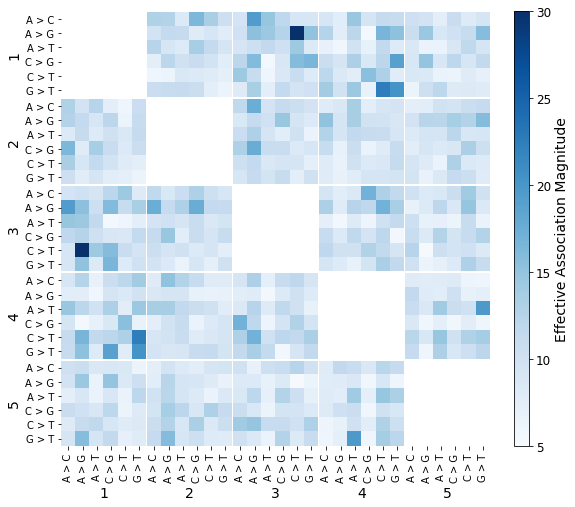

In [17]:
#
# Make plot
#

vmin = 5
vmax = 30

# ----------

labels = ['1','2','3','4','5']
ticks = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
ticklabels_dict = {}
for i in range(l):
    ticklabels_dict[i] = [mut[0]+' > '+mut[1] for mut in mutations_dict[i]]

fig = plt.figure(figsize=(8.5,8))
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[10,1], height_ratios=[1])
gs0 = gridspec.GridSpecFromSubplotSpec(l, l, subplot_spec=gs[0])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])

for i in range(l):
    for j in range(l):
        ax0 = fig.add_subplot(gs0[i,j])
        sns.heatmap(np.exp(rms_log_ORs[i*num_mut:(i+1)*num_mut,j*num_mut:(j+1)*num_mut]), 
                    vmin=vmin, vmax=vmax, square=True, annot=False, cmap='Blues', cbar=False)
        ax0.set_xticks([])
        ax0.set_yticks([])
        if i == (l-1):
            ax0.set_xticks(ticks=ticks)
            ax0.set_xticklabels(labels=ticklabels_dict[j], rotation='vertical') 
            ax0.set_xlabel('%s'%labels[j], fontsize=14)
        if j == 0:
            ax0.set_yticks(ticks=ticks)
            ax0.set_yticklabels(labels=ticklabels_dict[i], rotation='horizontal')
            ax0.set_ylabel('%s'%labels[i], fontsize=14)
            
plt.subplots_adjust(wspace=0.01, hspace=0.01)

ax1 = fig.add_subplot(gs1[0,0])
sns.heatmap(np.exp(rms_log_ORs), vmin=vmin, vmax=vmax, square=False, annot=False, cmap='Blues', cbar=False)
cbar = ax1.figure.colorbar(ax1.collections[0], fraction=0.5, aspect=30)
cbar.set_ticks([5, 10, 15, 20, 25, 30])
cbar.set_ticklabels(['5', '10', '15', '20', '25', '30'])
cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Effective Association Magnitude', size=14)
plt.gca().set_visible(False)

plt.show()

### (3d) Plot histograms of log odds ratios

Specify the following parameters:

`site_i` = one site <br>
`site_j` = another site

This will plot histograms of log odds ratios for all possible mutations at the two sites `site_i` and `site_j`. 

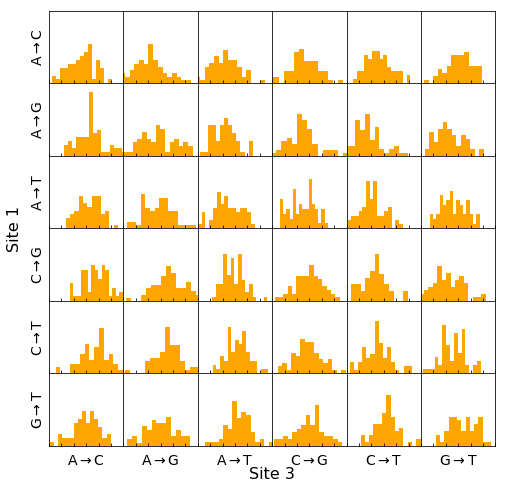

In [18]:
#
# Make plot
#

site_i = 1
site_j = 3

# ----------

labels = ['1','2','3','4','5']
ticklabels_dict = {}
for i in range(l):
    ticklabels_dict[i] = [r'%s$\rightarrow$%s'%(mut[0],mut[1]) for mut in mutations_dict[i]]

fig, axes = plt.subplots(num_mut, num_mut, figsize=(8,8))
k = 0
for m in range(num_mut):
    for n in range(num_mut):
        k += 1
        log_ORs = log_ORs_dict[(site_i-1,site_j-1)][k-1]
        plt.subplot(num_mut, num_mut, k)
        plt.hist(log_ORs, bins=15, density=True, color='orange')
        plt.ylim(0, 0.45)
        plt.xlim(-6, 6)
        plt.xticks([-6, -4, -2, 0, 2, 4, 6], [])
        plt.yticks([])
        plt.tick_params(axis='x', direction='in')
        if m == (num_mut-1):
            plt.xlabel('%s'%ticklabels_dict[site_j-1][n], fontsize=14)
        if n == 0:
            plt.ylabel('%s'%ticklabels_dict[site_i-1][m], fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Site %s'%labels[site_j-1], fontsize=16)
plt.ylabel('Site %s'%labels[site_i-1], fontsize=16)

plt.show()

## (4) Perform posterior sampling using Hamiltonian Monte Carlo

### (4a) Run multiple HMC chains with different initial phi

Specify the following parameters:

`num_chains` = number of HMC chains <br>
`num_samples_per_chain` = number of samples per HMC chain <br>
`num_warmup` = number of warmup draws <br>
`num_thinning` = number of thinning draws <br>
`e` = (initial) stepsize <br>
`L` = (initial) number of leapfrog steps <br>
`Le` = (fixed) product of `L` and `e` <br>
`window` = stepsize adaptation window <br>

This will run multiple HMC chains with different initial phi. The first `num_warmup` draws will be discarded, and from then on, samples will be picked every `num_thinning` draws. The stepsize `e` will be automatically adapted according to the acceptance rate in each period made of `window` draws. (For HMC, the target acceptance rate is 0.65.) The number of leapfrog steps `L` will be adapted accordingly, such that the product `Le` remains the same. The result will be saved in the 3D numpy array `multi_phi_samples`.

**Note.** The computation will take about 14 seconds.

In [19]:
num_chains = 10
num_samples_per_chain = 100
num_warmup = 1000
num_thinning = 10
e = 0.2
L = 5
Le = 1
window = 100

# ----------

method = 'hmc'
args = {'e': e, 
        'L': L,
        'Le': Le,
        'L_max': np.inf,
        'm': 1,
        'f': 0,
        'window': window,
        'gamma_old': 1,
        'gamma_new': 1,
        'perturbation': 2,
        'num_warmup': num_warmup,
        'num_thinning': num_thinning}
seeds = range(num_chains)

multi_phi_samples = np.zeros([num_chains, alpha**l, num_samples_per_chain])
for k in range(num_chains):    
    print('Running HMC chain # %d ...' % k)
    phi_initial, phi_samples, acceptance_rates = \
        posterior_sampling(phi_star, a_star, data_dict, num_samples_per_chain, method, args, random_seed=seeds[k])
    multi_phi_samples[k,:,:] = phi_samples
    print('acceptance_rates in the sampling phase per window =', acceptance_rates[10:])
    print()

Running HMC chain # 0 ...
acceptance_rates in the sampling phase per window = [0.73, 0.66, 0.64, 0.7, 0.49, 0.8, 0.61, 0.68, 0.67, 0.67]

Running HMC chain # 1 ...
acceptance_rates in the sampling phase per window = [0.7, 0.64, 0.65, 0.63, 0.66, 0.63, 0.55, 0.66, 0.57, 0.65]

Running HMC chain # 2 ...
acceptance_rates in the sampling phase per window = [0.59, 0.63, 0.71, 0.7, 0.6, 0.66, 0.67, 0.75, 0.56, 0.66]

Running HMC chain # 3 ...
acceptance_rates in the sampling phase per window = [0.63, 0.71, 0.64, 0.67, 0.74, 0.65, 0.61, 0.57, 0.56, 0.65]

Running HMC chain # 4 ...
acceptance_rates in the sampling phase per window = [0.71, 0.64, 0.7, 0.6, 0.69, 0.65, 0.64, 0.62, 0.62, 0.6]

Running HMC chain # 5 ...
acceptance_rates in the sampling phase per window = [0.56, 0.68, 0.66, 0.76, 0.71, 0.54, 0.57, 0.69, 0.76, 0.68]

Running HMC chain # 6 ...
acceptance_rates in the sampling phase per window = [0.62, 0.59, 0.69, 0.64, 0.63, 0.64, 0.72, 0.72, 0.75, 0.65]

Running HMC chain # 7 ...
ac

### (4b) Compute R_hat for each component of phi

If the HMC chains are well mixed, the "potential scale reduction factors" `R_hats` of all the components of phi should be around 1. If this is not the case, redo (4a) with a larger value of `Le`. 

In [20]:
R_hats = compute_R_hat(multi_phi_samples)
print('R_hat: %.3f (# %d) ~ %.3f (# %d)' % (R_hats.min(), R_hats.argmin(), R_hats.max(), R_hats.argmax()))

R_hat: 0.996 (# 995) ~ 1.030 (# 802)


### (4c) Combine all samples

If satisfied with the samples, turn the 3D numpy array `multi_phi_samples` into a 2D numpy array `phi_samples`.

In [21]:
phi_samples = combine_samples(multi_phi_samples)

### (4d) Plot distribution of the i-th component of phi

Specify the following parameters:

`ii` = list of components of phi 

This will plot marginal distribution of these `ii` components of phi, along with the MAP estimate. 

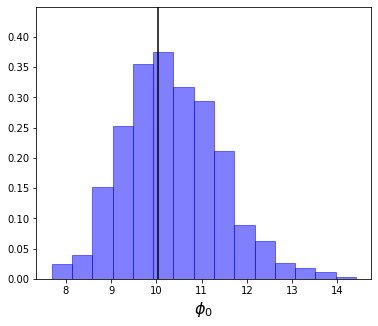

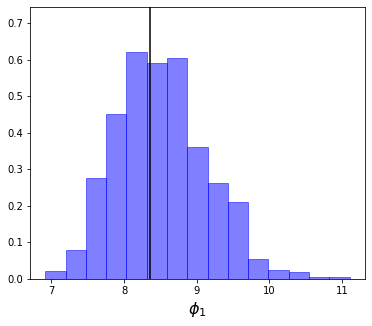

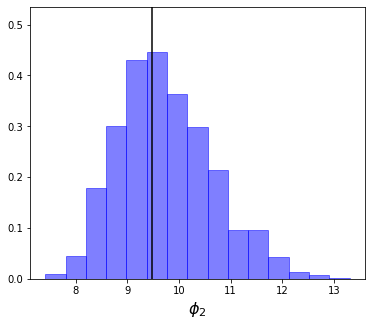

In [22]:
ii = [0, 1, 2]

# ----------

phi_samples_list = [phi_samples]
phi_map = phi_star
num_bins = 15
colors=['blue']

for i in ii:
    plot_distribution(i, phi_samples_list, phi_map, num_bins, colors)